In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import nltk; nltk.download('stopwords')
!python3 -m spacy download en_core_web_sm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


2023-08-21 09:46:24.339166: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 09:46:25.677868: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 23.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# !pip install pyLDAvis==2.1.2

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import tqdm

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings(action = 'ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import ParameterGrid

# spacy for lemmatization
import spacy

# Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this

import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

prepare stopwords

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['re', 'edu', 'hi', 'Hi', 'thank', 's', 'thanks', 'please', 'ok'])

import json file data

In [ ]:
df = pd.read_json('/content/chat_data.json')
df.head()

,1015096786,1015274995,1015275252,1015275450,1015275456,1015275479,1015275235,1015275488,1015298501,1015322814,...,1840060617,1840513982,1840464847,1841349819,1841350088,1841350642,1839841735,1841424091,1841431282,1841433317
status,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,...,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,CLOSED,OPEN,OPEN,OPEN
inboxId,70348980,70348980,70348980,70348980,70348980,70348980,70348980,70348980,70348980,70348980,...,70348980,70348980,70348980,70348980,70348980,70348980,70348980,70348980,70348980,70348980
messages,"[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...",...,"[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'...","[{'text': None, 'updatedAt': None, 'direction'..."


Transpose dataframe to long

In [ ]:
df_long = df.transpose()
df_long

,status,inboxId,messages
1015096786,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1015274995,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1015275252,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1015275450,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1015275456,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
...,...,...,...
1841350642,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1839841735,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1841424091,OPEN,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1841431282,OPEN,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."


In [ ]:
df_long.info

<bound method DataFrame.info of             status   inboxId  \
1015096786  CLOSED  70348980   
1015274995  CLOSED  70348980   
1015275252  CLOSED  70348980   
1015275450  CLOSED  70348980   
1015275456  CLOSED  70348980   
...            ...       ...   
1841350642  CLOSED  70348980   
1839841735  CLOSED  70348980   
1841424091    OPEN  70348980   
1841431282    OPEN  70348980   
1841433317    OPEN  70348980   

                                                     messages  
1015096786  [{'text': None, 'updatedAt': None, 'direction'...  
1015274995  [{'text': None, 'updatedAt': None, 'direction'...  
1015275252  [{'text': None, 'updatedAt': None, 'direction'...  
1015275450  [{'text': None, 'updatedAt': None, 'direction'...  
1015275456  [{'text': None, 'updatedAt': None, 'direction'...  
...                                                       ...  
1841350642  [{'text': None, 'updatedAt': None, 'direction'...  
1839841735  [{'text': None, 'updatedAt': None, 'direction'...  
1841424

Set index as the id of the conversations

In [ ]:
df_long.set_index(df_long.columns[0])
df_long.index.name = 'index'
df_long

,status,inboxId,messages
index,,,
1015096786,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1015274995,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1015275252,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1015275450,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1015275456,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
...,...,...,...
1841350642,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1839841735,CLOSED,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."
1841424091,OPEN,70348980,"[{'text': None, 'updatedAt': None, 'direction'..."


Cleaning up conversation and create histogram of most common message

In [ ]:
from collections import defaultdict
import time
conversations = df_long.messages.tolist()

# clean up conversation
def valid(messages):
  if len(messages) <= 3:
    return False;
  # find first not null message
  firstRealMessage = next(filter(lambda message: message["text"] is not None, messages), None)
  # if the message contains 'not been active', remove it
  if "not been active" in firstRealMessage["text"]:
    return False;
  return True;


sanitized_conversations = list(filter(valid, conversations));
print(len(sanitized_conversations)) #3778 left

# creating a dictionary returning 0 instead of error if empty
# use as a count method
histo = defaultdict(int)
# sort histogram count for message frequency
for conversation in sanitized_conversations:
  for message in conversation:
    if message["text"] is not None:
      histo[message["text"]] += 1
sorted_histo = sorted(histo.items(), key=lambda x:x[1], reverse=True)

for i in range(50):
  print(sorted_histo[i])



4477
('Please note, residential lending is currently via exclusive limited distribution only.', 3440)
('So we can put you in touch with the right team, tell us a bit about yourself...', 3313)
('You’re on your way to a better experience, more certainty and more control 💥', 3306)
("I'm an <CASE_IDENTIFIER> broker!", 3226)
('<EMAIL_ADDRESS>', 2325)
('Awesome! What can we help you with today?', 2307)
('<NAME> <NAME>', 1543)
('Something <NAME>', 1386)
("<NAME> <NAME>, thanks for reaching out to <CASE_IDENTIFIER> Broker Support! I'm <NAME> and I'll be assisting you. Let me take a moment to read what you've shared.", 1337)
('Amazing stuff Superhero! What’s your name?', 1322)
("Cool, thanks <NAME>. What's your email address registered with <CASE_IDENTIFIER>?", 1280)
('Do you have a criteria question?', 1122)
("I'm going to close this chat. Our marketing team might reach out to get your feedback, I'd <NAME> to hear it! This feedback allows me to grow as a support specialist and continue to prov

In [ ]:
# remove conversations that are None by filtering out the null messages
print(sanitized_conversations[0])
for i, conversation in enumerate(sanitized_conversations):
    sanitized_conversations[i] = list(filter(lambda message: message["text"] is not None, conversation))
print(sanitized_conversations[:2])

[{'text': None, 'updatedAt': None, 'direction': None}, {'text': None, 'updatedAt': None, 'direction': None}, {'text': None, 'updatedAt': None, 'direction': None}, {'text': None, 'updatedAt': None, 'direction': None}, {'text': "First Name: <NAME>\nLast Name: <NAME>\nEmail: <EMAIL_ADDRESS>\nWhy I&#x27;m submitting a request...: Something's broken\nAre you raising this ticket on behalf of a broker?: No\nCategory: Platform (kanban)\nPlatform subcategories: Access issues\nIssue: Used to be able to access the LIVE platform - no longer have access\n<NAME> issue: No\n", 'updatedAt': '2022-02-14T10:09:31.672Z', 'direction': 'INCOMING'}]
[[{'text': "First Name: <NAME>\nLast Name: <NAME>\nEmail: <EMAIL_ADDRESS>\nWhy I&#x27;m submitting a request...: Something's broken\nAre you raising this ticket on behalf of a broker?: No\nCategory: Platform (kanban)\nPlatform subcategories: Access issues\nIssue: Used to be able to access the LIVE platform - no longer have access\n<NAME> issue: No\n", 'updatedAt

In [ ]:
# delete non-live conversation that doesn't connect to a customer support
def counter(messages):
  for message in messages:
    if "a member of our Broker Support team now" in message['text']:
      return True
  return False

sanitized_conversations = list(filter(counter, sanitized_conversations));
print(len(sanitized_conversations))

2656


In [ ]:
pprint(sanitized_conversations[:6])
print('-------------------')

[[{'direction': 'OUTGOING',
   'text': 'Ok.  Enjoy your <NAME> and thank you for contacting '
           '<CASE_IDENTIFIER>!',
   'updatedAt': '2022-05-18T09:20:17.195Z'},
  {'direction': 'INCOMING',
   'text': 'no thank you :)',
   'updatedAt': '2022-05-18T09:19:45.672Z'},
  {'direction': 'OUTGOING',
   'text': "You're welcome!  Is there anything <NAME> I can help you with?",
   'updatedAt': '2022-05-18T09:19:19.416Z'},
  {'direction': 'INCOMING',
   'text': 'thats very helpful',
   'updatedAt': '2022-05-18T09:18:37.079Z'},
  {'direction': 'INCOMING',
   'text': 'got it. thank you\xa0',
   'updatedAt': '2022-05-18T09:18:33.274Z'},
  {'direction': 'OUTGOING',
   'text': 'You can download your application by logging into your portal.  '
           'Before you click through to view <NAME> you will see a drop down '
           'arrow that will show a <NAME> of documents.  One of those '
           "documents will be called 'Broker's Audit'.  This will be detail of "
           'everything

In [ ]:
# find message where it connect to support team and delete everything after
# or other messages that is autogen
for conv in sanitized_conversations:
  for i, message in enumerate(conv):
    if "a member of our Broker Support team" in message["text"]:
      del conv[i:len(conv)]

sanitized_conversations_filtered = []
for conv in sanitized_conversations:
  filtered_conv = []
  for i, message in enumerate(conv):
    if "residential lending is currently via exclusive limited" in message["text"]:
      continue;
    if "take a moment to read what you've shared" in message["text"]:
      continue;
    if "going to close this chat" in message["text"]:
      continue;
    if "busier than usual" in message["text"]:
      continue;
    if "and I'll be assisting you" in message["text"]:
      continue;
    if "bear with me" in message["text"]:
      continue;
    if "Is there anything" in message["text"]:
      continue;
    if "is there anything" in message["text"]:
      continue;
    if "security questions" in message["text"]:
      continue;
    if "can I assist" in message["text"]:
      continue;
    filtered_conv.append(message)
  sanitized_conversations_filtered.append(filtered_conv)


In [ ]:
pprint(sanitized_conversations_filtered[:6])

[[{'direction': 'OUTGOING',
   'text': 'Ok.  Enjoy your <NAME> and thank you for contacting '
           '<CASE_IDENTIFIER>!',
   'updatedAt': '2022-05-18T09:20:17.195Z'},
  {'direction': 'INCOMING',
   'text': 'no thank you :)',
   'updatedAt': '2022-05-18T09:19:45.672Z'},
  {'direction': 'INCOMING',
   'text': 'thats very helpful',
   'updatedAt': '2022-05-18T09:18:37.079Z'},
  {'direction': 'INCOMING',
   'text': 'got it. thank you\xa0',
   'updatedAt': '2022-05-18T09:18:33.274Z'},
  {'direction': 'OUTGOING',
   'text': 'You can download your application by logging into your portal.  '
           'Before you click through to view <NAME> you will see a drop down '
           'arrow that will show a <NAME> of documents.  One of those '
           "documents will be called 'Broker's Audit'.  This will be detail of "
           'everything that has been keyed to the application.',
   'updatedAt': '2022-05-18T09:17:43.335Z'},
  {'direction': 'INCOMING',
   'text': 'submitted one',
   'up

In [ ]:
# remove angle bracket content, remove newline characters, remove single and double quotes
for conversation in sanitized_conversations_filtered:
  for message in conversation:
    message['text'] = re.sub('[\<(\[].*?[\>)\]]', '', message['text'])
    message['text'] = re.sub('\s+', ' ', message['text'])
    message['text'] = re.sub('\'', ' ', message['text'])

pprint(sanitized_conversations_filtered[:5])

[[{'direction': 'OUTGOING',
   'text': 'Ok. Enjoy your and thank you for contacting !',
   'updatedAt': '2022-05-18T09:20:17.195Z'},
  {'direction': 'INCOMING',
   'text': 'no thank you :)',
   'updatedAt': '2022-05-18T09:19:45.672Z'},
  {'direction': 'INCOMING',
   'text': 'thats very helpful',
   'updatedAt': '2022-05-18T09:18:37.079Z'},
  {'direction': 'INCOMING',
   'text': 'got it. thank you ',
   'updatedAt': '2022-05-18T09:18:33.274Z'},
  {'direction': 'OUTGOING',
   'text': 'You can download your application by logging into your portal. '
           'Before you click through to view you will see a drop down arrow '
           'that will show a of documents. One of those documents will be '
           'called  Broker s Audit . This will be detail of everything that '
           'has been keyed to the application.',
   'updatedAt': '2022-05-18T09:17:43.335Z'},
  {'direction': 'INCOMING',
   'text': 'submitted one',
   'updatedAt': '2022-05-18T09:15:45.810Z'},
  {'direction': 'INC

In [ ]:
# add messages to new list
words = []
for conv in sanitized_conversations_filtered:
  for message in conv:
      words.append(message['text'])

print(words[:2])
print(len(words))
print(len(words[1]))

print(words[3800:3801])
print(type(words))

['Ok. Enjoy your and thank you for contacting !', 'no thank you :)']
30122
15
['Underwriting has up to review ']
<class 'list'>


In [ ]:
# tokenize(split sentences into words) words + clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

clean_words = remove_stopwords(words)
clean_words = list(sent_to_words(clean_words))

print(clean_words[3850])


['look']


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(clean_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[clean_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[clean_words[3850]]])

['look']


In [ ]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Form Bigrams
clean_words_bigrams = make_bigrams(clean_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(clean_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])
print(data_lemmatized[3850])

[['enjoy', 'contact'], []]
['look']


In [ ]:
# hyperparameter tuning
word_params = {
    "vector_size":[50, 100, 200, 300],
    "window":[3, 5, 8, 10],
    "min_count":[1]
}
kmeans_params = {
    "n_clusters":[x for x in range(5, 20, 1)]
    }

best_kmeans_model = None
best_kmeans_score = float('-inf')

v50_score = []
v100_score = []
v200_score = []
v300_score = []

for kparams in ParameterGrid(kmeans_params):
  for wordparams in ParameterGrid(word_params):
    word2vec_model = gensim.models.Word2Vec(clean_words, **wordparams, seed=1) # seed=1
    word_vector = word2vec_model.wv

    k_model = KMeans(n_clusters=kparams['n_clusters'], random_state=1)
    cluster_label = k_model.fit_predict(word_vector.vectors)

    silhouette = silhouette_score(word_vector.vectors, cluster_label)
    print("word2vec combo", wordparams)
    print("model:", k_model, "model score:", silhouette)
    print("----------------------------------------")

    config = wordparams
    config['score'] = silhouette
    config['cluster'] = kparams['n_clusters']

    if wordparams['vector_size'] == 50:
      v50_score.append(config)
    if wordparams['vector_size'] == 100:
      v100_score.append(config)
    if wordparams['vector_size'] == 200:
      v200_score.append(config)
    if wordparams['vector_size'] == 300:
      v300_score.append(config)

    if silhouette > best_kmeans_score:
      best_kmeans_score = silhouette
      best_kmeans_model = k_model

print("Best KMeans Model Hyperparameters:", best_kmeans_model)

word2vec combo {'min_count': 1, 'vector_size': 50, 'window': 3}
model: KMeans(n_clusters=5, random_state=1) model score: 0.5934847
----------------------------------------
[{'min_count': 1, 'vector_size': 50, 'window': 3, 'score': 0.5934847, 'cluster': 5}]
word2vec combo {'min_count': 1, 'vector_size': 50, 'window': 5}
model: KMeans(n_clusters=5, random_state=1) model score: 0.63877827
----------------------------------------
[{'min_count': 1, 'vector_size': 50, 'window': 3, 'score': 0.5934847, 'cluster': 5}, {'min_count': 1, 'vector_size': 50, 'window': 5, 'score': 0.63877827, 'cluster': 5}]
word2vec combo {'min_count': 1, 'vector_size': 50, 'window': 8}
model: KMeans(n_clusters=5, random_state=1) model score: 0.64881116
----------------------------------------
[{'min_count': 1, 'vector_size': 50, 'window': 3, 'score': 0.5934847, 'cluster': 5}, {'min_count': 1, 'vector_size': 50, 'window': 5, 'score': 0.63877827, 'cluster': 5}, {'min_count': 1, 'vector_size': 50, 'window': 8, 'score':

In [ ]:
pprint(v50_score)
pprint(v100_score)
pprint(v200_score)
pprint(v300_score)

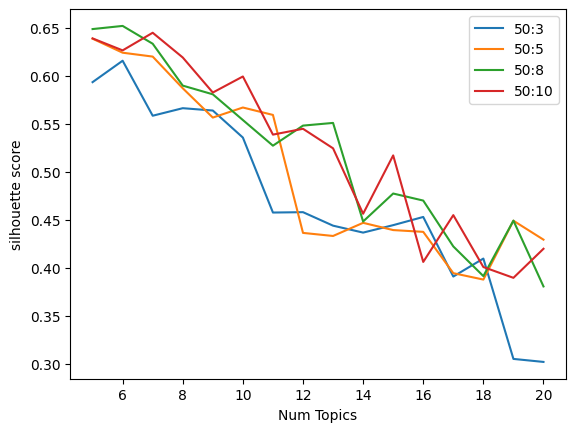

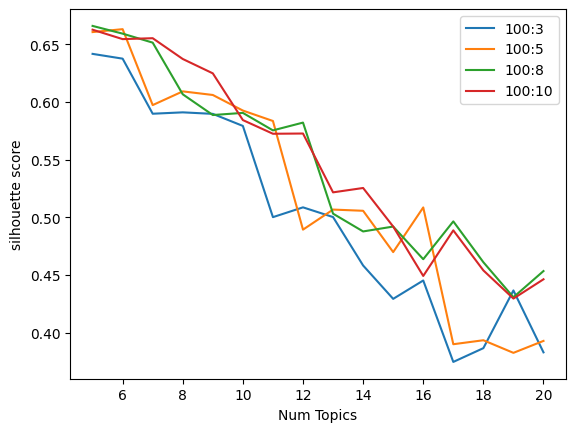

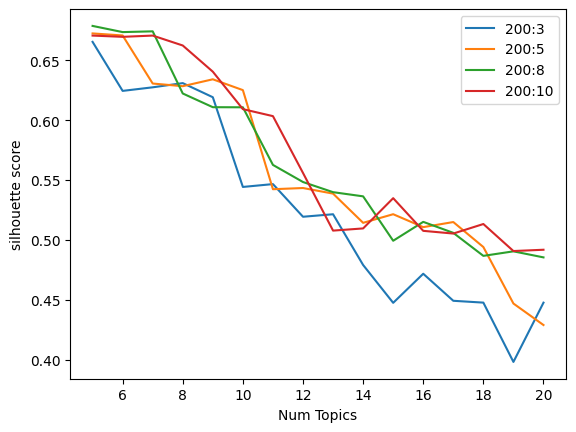

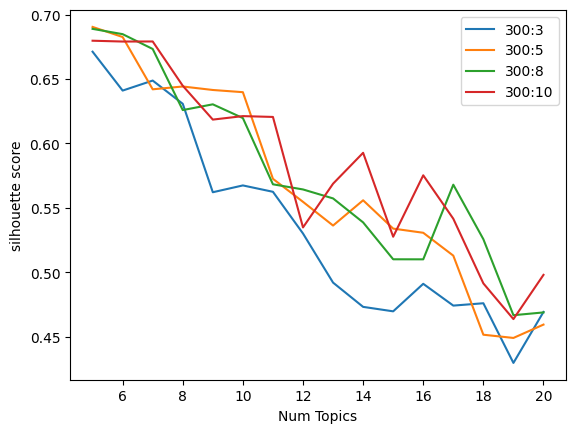

In [ ]:
plt.plot(kmeans_params['n_clusters'],[score['score'] for score in v50_score if score['window'] == 3], label='50:3')
plt.plot(kmeans_params['n_clusters'],[score['score'] for score in v50_score if score['window'] == 5], label='50:5')
plt.plot(kmeans_params['n_clusters'],[score['score'] for score in v50_score if score['window'] == 8], label='50:8')
plt.plot(kmeans_params['n_clusters'],[score['score'] for score in v50_score if score['window'] == 10], label='50:10')
plt.xlabel("Num Topics")
plt.ylabel("silhouette score")
plt.legend()
plt.show()

plt.plot(kmeans_params['n_clusters'],[score['score'] for score in v100_score if score['window'] == 3], label='100:3')
plt.plot(kmeans_params['n_clusters'],[score['score'] for score in v100_score if score['window'] == 5], label='100:5')
plt.plot(kmeans_params['n_clusters'],[score['score'] for score in v100_score if score['window'] == 8], label='100:8')
plt.plot(kmeans_params['n_clusters'],[score['score'] for score in v100_score if score['window'] == 10], label='100:10')
plt.xlabel("Num Topics")
plt.ylabel("silhouette score")
plt.legend()
plt.show()

plt.plot(kmeans_params['n_clusters'],[score['score'] for score in v200_score if score['window'] == 3], label='200:3')
plt.plot(kmeans_params['n_clusters'],[score['score'] for score in v200_score if score['window'] == 5], label='200:5')
plt.plot(kmeans_params['n_clusters'],[score['score'] for score in v200_score if score['window'] == 8], label='200:8')
plt.plot(kmeans_params['n_clusters'],[score['score'] for score in v200_score if score['window'] == 10], label='200:10')
plt.xlabel("Num Topics")
plt.ylabel("silhouette score")
plt.legend()
plt.show()

plt.plot(kmeans_params['n_clusters'],[score['score'] for score in v300_score if score['window'] == 3], label='300:3')
plt.plot(kmeans_params['n_clusters'],[score['score'] for score in v300_score if score['window'] == 5], label='300:5')
plt.plot(kmeans_params['n_clusters'],[score['score'] for score in v300_score if score['window'] == 8], label='300:8')
plt.plot(kmeans_params['n_clusters'],[score['score'] for score in v300_score if score['window'] == 10], label='300:10')
plt.xlabel("Num Topics")
plt.ylabel("silhouette score")
plt.legend()
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
# embed word2vec model
# Create CBOW model
w2v_cbow = gensim.models.Word2Vec(clean_words, min_count = 1, vector_size = 300, window = 5, sg = 0, seed=1) #sg=0 cbow sg=1 skipgram

# Create Skip Gram model
# w2v_sg = gensim.models.Word2Vec(clean_words, min_count = 1, vector_size = 100, window = 3, sg = 1)

print(w2v_cbow)
vocabulary = w2v_cbow.wv.key_to_index
print(len(vocabulary))
print(vocabulary)

vector = w2v_cbow.wv.vectors

Word2Vec<vocab=6205, vector_size=300, alpha=0.025>
6205
{'help': 0, 'would': 1, 'need': 2, 'yes': 3, 'great': 4, 'client': 5, 'see': 6, 'email': 7, 'today': 8, 'income': 9, 'offer': 10, 'check': 11, 'get': 12, 'confirm': 13, 'mortgage': 14, 'application': 15, 'also': 16, 'address': 17, 'hello': 18, 'number': 19, 'broker': 20, 'property': 21, 'let': 22, 'able': 23, 'could': 24, 'loan': 25, 'one': 26, 'affordability': 27, 'residential': 28, 'unfortunately': 29, 'new': 30, 'know': 31, 'take': 32, 'us': 33, 'sorry': 34, 'name': 35, 'problem': 36, 'system': 37, 'patience': 38, 'looking': 39, 'accept': 40, 'welcome': 41, 'applicant': 42, 'thats': 43, 'time': 44, 'okay': 45, 'documents': 46, 'use': 47, 'underwriting': 48, 'sure': 49, 'details': 50, 'however': 51, 'aip': 52, 'reference': 53, 'correct': 54, 'amount': 55, 'calculator': 56, 'products': 57, 'clients': 58, 'question': 59, 'last': 60, 'registered': 61, 'contact': 62, 'waiting': 63, 'go': 64, 'solicitors': 65, 'chat': 66, 'ltv': 67, 

In [ ]:
# get vector of word
w2v_cbow.wv['income']
len(w2v_cbow.wv['income'])

In [ ]:
# option of querying similar words
w2v_cbow.wv.most_similar('affordability')

KMeans------------------------------------------

In [ ]:
cluster = 10
km = KMeans(n_clusters=cluster).fit(vector)
print(f"For n_clusters = {cluster}")
print(f"Silhouette coefficient: {silhouette_score(vector, km.labels_):0.2f}")
print(f"Inertia:{km.inertia_}")

sample_silhouette_values = silhouette_samples(vector, km.labels_)
print(f"Silhouette values:")
silhouette_values = []
for i in range(cluster):
    cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
    silhouette_values.append(
        (
            i,
            cluster_silhouette_values.shape[0],
            cluster_silhouette_values.mean(),
            cluster_silhouette_values.min(),
            cluster_silhouette_values.max(),
        )
    )
silhouette_values = sorted(
    silhouette_values, key=lambda tup: tup[2], reverse=True
)
for s in silhouette_values:
    print(f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}")


For n_clusters = 10
Silhouette coefficient: 0.64
Inertia:487.0325012207031
Silhouette values:
    Cluster 0: Size:4294 | Avg:0.76 | Min:0.05 | Max: 0.84
    Cluster 4: Size:860 | Avg:0.44 | Min:-0.04 | Max: 0.66
    Cluster 2: Size:429 | Avg:0.43 | Min:-0.06 | Max: 0.66
    Cluster 3: Size:268 | Avg:0.32 | Min:-0.12 | Max: 0.58
    Cluster 5: Size:13 | Avg:0.28 | Min:-0.11 | Max: 0.51
    Cluster 6: Size:200 | Avg:0.26 | Min:-0.11 | Max: 0.50
    Cluster 9: Size:15 | Avg:0.25 | Min:-0.13 | Max: 0.47
    Cluster 8: Size:50 | Avg:0.14 | Min:-0.12 | Max: 0.36
    Cluster 7: Size:20 | Avg:0.11 | Min:-0.21 | Max: 0.34
    Cluster 1: Size:56 | Avg:0.09 | Min:-0.23 | Max: 0.34


In [ ]:
print("Most representative terms per cluster (based on centroids):")
for i in range(cluster):
    tokens_per_cluster = ""
    most_representative = w2v_cbow.wv.most_similar(positive=[km.cluster_centers_[i]], topn=15)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Most representative terms per cluster (based on centroids):
Cluster 0: shared doesnt cost national thought info far makes private lease recently england housing school circumstances 
Cluster 1: yet inbox resent user created set solicitor resend directly confirming received offered screenshot addresses shall 
Cluster 2: lease cost shared makes thought ago customers likely housing school doesnt fully receiving private court 
Cluster 3: cost lease likely ago thought fully makes school shared doesnt info housing understand national recommend 
Cluster 4: shared cost lease doesnt makes thought far national housing private school info circumstances customers cash 
Cluster 5: name security confirm address broker mobile location trading provide congleton telephone plymouth subject nad number 
Cluster 6: lease guys taking dont st ago start standard factor fully normal portfolio recommend filled shop 
Cluster 7: keep open issue response feel regarding lines live waiting eye apologies going delay 

In [ ]:
test_cluster = 4
most_representative_docs = np.argsort(
    np.linalg.norm(vector - km.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:1000]:
    print(words[d])

£
Hi, I have a mtg enquiry please
ok perfect.. The awkward thing is the savings are in investments so she has to request for them to be drawn on and it will take a while.. Shes to in a rate now..
Thank you for providing the security information. Are you able to tell me what type of document you are trying to upload?
Bear with to check with an underwriter.
Have a great .
Oh ok, so I want to have only , as that would be a better cost for the client, ok so the only way to do this, is the way I have submitted the already? 
hi 
It looks like you ve not been active for a while . I am going to close our chat now. If you have any further questions regarding your issue, please free to contact me again through live chat or email. Have a great !
It looks like you ve not been active for a while . I am going to close our chat now. If you have any further questions regarding your issue, please free to contact me again through live chat or email. Have a great !
Unfortunately we do not accept - constr